# Plot results from ROS bag

In [1]:
import rosbag2_py
import os
from nav_msgs.msg import Odometry
from geometry_msgs.msg import Pose, PoseWithCovarianceStamped
from rclpy.serialization import deserialize_message
import matplotlib.pyplot as plt
from project.utils import angle_from_quaternion

print(os.getcwd())
bag_file = "/home/ubuntu/34761-Exercises/src/project/bag_files/test_with_cov5"
reader = rosbag2_py.SequentialReader()
storage_options = rosbag2_py.StorageOptions(uri=bag_file, storage_id='sqlite3')
converter_options = rosbag2_py.ConverterOptions(input_serialization_format='cdr', output_serialization_format='cdr')
reader.open(storage_options, converter_options)

# Create empty lists to store the data
topics = ["/odom", "/amcl_pose", "/particle_estimation_own"]
data_keys = ["x", "y", "angle", "cov", "Timestamp"]
data_dict = {topic: {key: [] for key in data_keys} for topic in topics}

# Collect data
topics = set()
while reader.has_next():
    topic, data, timestamp = reader.read_next()
    topics.add(topic)
    if topic in data_dict.keys():
        # Deserialize the message
        msg = None
        if topic == "/odom":
            msg = deserialize_message(data, Odometry())
            data_dict[topic]["x"].append(msg.pose.pose.position.x)
            data_dict[topic]["y"].append(msg.pose.pose.position.y)
            data_dict[topic]["angle"].append(angle_from_quaternion(msg.pose.pose.orientation))
            data_dict[topic]["cov"].append(msg.pose.covariance)
        elif topic == "/amcl_pose" or topic == "/particle_estimation_own":
            msg = deserialize_message(data, PoseWithCovarianceStamped())
            data_dict[topic]["x"].append(msg.pose.pose.position.x)
            data_dict[topic]["y"].append(msg.pose.pose.position.y)
            data_dict[topic]["angle"].append(angle_from_quaternion(msg.pose.pose.orientation))
        data_dict[topic]["Timestamp"].append(msg.header.stamp.sec * 1e9 + msg.header.stamp.nanosec)
# Fix timestamps to start from 0 and from ns to seconds
latest_first_time = min([min(data_dict[key]["Timestamp"]) for key in data_dict.keys()])
for key in data_dict.keys():
    data_dict[key]["Timestamp"] = [(t - latest_first_time) / 1e9 for t in data_dict[key]["Timestamp"]]
    print(f"First timestamp for {key}: {data_dict[key]['Timestamp'][0]}")

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[INFO] [1714467985.953196057] [rosbag2_storage]: Opened database '/home/ubuntu/34761-Exercises/src/project/bag_files/test_with_cov5/test_with_cov5_0.db3' for READ_ONLY.


/home/ubuntu/34761-Exercises/src/project
First timestamp for /odom: 35.92
First timestamp for /amcl_pose: 0.0
First timestamp for /particle_estimation_own: 47.88


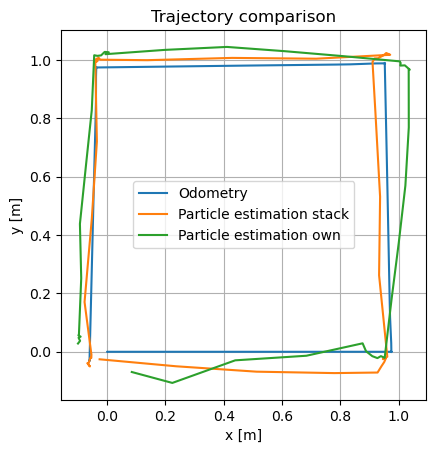

In [2]:
# Plot data
plt.figure()
plt.plot(data_dict["/odom"]["x"], data_dict["/odom"]["y"], label="Odometry")
plt.plot(data_dict["/amcl_pose"]["x"], data_dict["/amcl_pose"]["y"], label="Particle estimation stack")
plt.plot(data_dict["/particle_estimation_own"]["x"], data_dict["/particle_estimation_own"]["y"], label="Particle estimation own")
plt.legend()
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.title("Trajectory comparison")
plt.grid()
plt.gca().set_aspect('equal', adjustable='box')
    
plt.show()

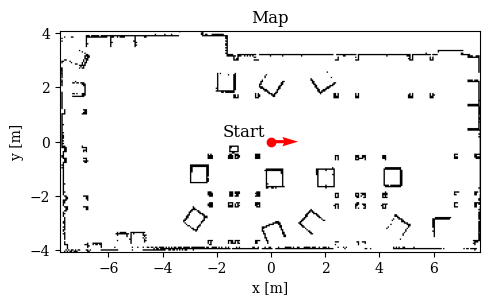

In [74]:
import matplotlib.pyplot as plt
import numpy as np
import yaml

def plot_map(map_image_path, map_yaml_path, ax):
    # Load the map image from the .pgm file
    map_image = plt.imread(map_image_path)
    map_image[map_image != 0] = 254

    # Load the meta information from the yaml file
    with open(map_yaml_path, 'r') as file:
        meta_info = yaml.safe_load(file)

    # Extract the map resolution and origin from the meta information
    resolution = meta_info['resolution']
    origin = meta_info['origin']

    # Get the map dimensions
    height, width = map_image.shape

    # Create a grid of x and y coordinates
    x = np.arange(0, width) * resolution + origin[0]
    y = np.arange(0, height) * resolution + origin[1]

    # Plot the map
    ax.imshow(map_image, cmap='gray', extent=[x.min(), x.max(), y.min(), y.max()])

# Create a figure and axes, and call the function with the paths to your map image and yaml file
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plot_map('../../assets/maps/map.pgm', '../../assets/maps/map.yaml', ax)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_title('Map')
ax.set_aspect('equal', adjustable='box')
ax.plot(0, 0, 'ro', label='Start')
ax.text(-0.2, 0.2, 'Start', fontsize=12, ha='right')
ax.quiver(0, 0, 1, 0, scale=1, scale_units='xy', angles='xy', color='r')
plt.tight_layout()
plt.savefig("../../assets/map.pdf",bbox_inches='tight')
plt.show()

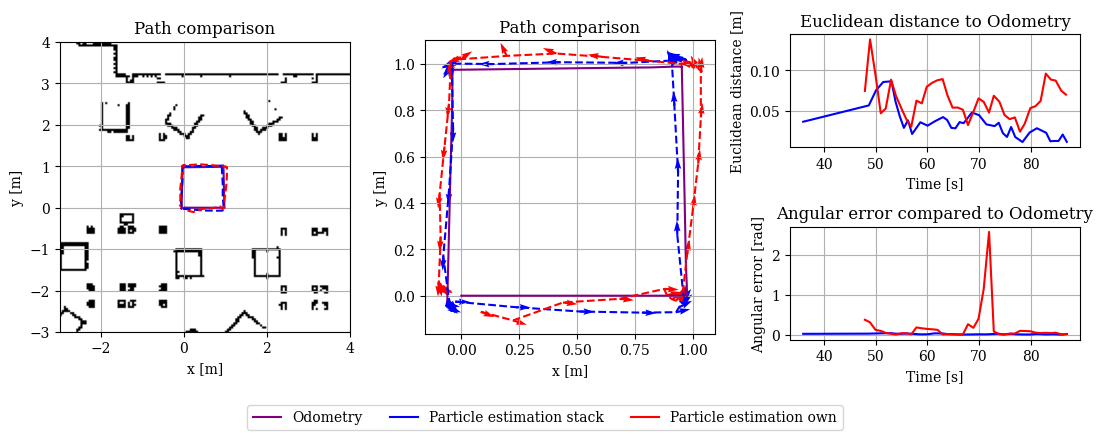

In [54]:
import numpy as np

# Plot Euclidean distance
odom_x = np.array(data_dict["/odom"]["x"])
odom_y = np.array(data_dict["/odom"]["y"])
stack_x = np.array(data_dict["/amcl_pose"]["x"])
stack_y = np.array(data_dict["/amcl_pose"]["y"])
own_x = np.array(data_dict["/particle_estimation_own"]["x"])
own_y = np.array(data_dict["/particle_estimation_own"]["y"])
odom_angle = np.array(data_dict["/odom"]["angle"])
stack_angle = np.array(data_dict["/amcl_pose"]["angle"])
own_angle = np.array(data_dict["/particle_estimation_own"]["angle"])
# Convert timestamps to numpy arrays
odom_timestamps = np.array(data_dict["/odom"]["Timestamp"])
stack_timestamps = np.array(data_dict["/amcl_pose"]["Timestamp"])
own_timestamps = np.array(data_dict["/particle_estimation_own"]["Timestamp"])

# Find the indices of the closest Odometry timestamps
stack_indices = np.searchsorted(odom_timestamps, stack_timestamps)
own_indices = np.searchsorted(odom_timestamps, own_timestamps)

# Use these indices to get the corresponding Odometry data
odom_x_stack = odom_x[stack_indices]
odom_y_stack = odom_y[stack_indices]
odom_angle_stack = odom_angle[stack_indices]
odom_x_own = odom_x[own_indices]
odom_y_own = odom_y[own_indices]
odom_angle_own = odom_angle[own_indices]

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines

# Enable LaTeX text rendering
plt.rcParams['font.family'] = 'serif'
# Create a gridspec
gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1], width_ratios=[1, 1, 1])

# Create subplots
fig = plt.figure(figsize=(11, 4))
ax1 = plt.subplot(gs[:, 0])  # Trajectory comparison plot
ax1_2 = plt.subplot(gs[:, 1])  # Trajectory comparison plot
ax2 = plt.subplot(gs[0, 2])  # Euclidean distance plot
ax3 = plt.subplot(gs[1, 2])  # Angle error plot

# Calculate dx and dy based on angle
dx_stack = np.cos(data_dict["/amcl_pose"]["angle"])
dy_stack = np.sin(data_dict["/amcl_pose"]["angle"])
dx_own = np.cos(data_dict["/particle_estimation_own"]["angle"])
dy_own = np.sin(data_dict["/particle_estimation_own"]["angle"])

# Plot trajectories
ax1.plot(data_dict["/odom"]["x"], data_dict["/odom"]["y"], color='purple', label="Odometry")
ax1.plot(data_dict["/amcl_pose"]["x"], data_dict["/amcl_pose"]["y"], color='blue', label="Particle estimation stack", linestyle='dashed')
ax1.plot(data_dict["/particle_estimation_own"]["x"], data_dict["/particle_estimation_own"]["y"], color='red', label="Particle estimation own", linestyle='dashed')

# Add arrows to the plot
plot_map('../../assets/maps/map.pgm', '../../assets/maps/map.yaml', ax1)
ax1.set_xlabel("x [m]")
ax1.set_ylabel("y [m]")
ax1.set_xlim(-3., 4.)
ax1.set_ylim(-3., 4.)
ax1.set_title("Path comparison")
ax1.grid()
ax1.set_aspect('equal', adjustable='box')

# Plot trajectories
ax1_2.plot(data_dict["/odom"]["x"], data_dict["/odom"]["y"], color='purple', label="Odometry")
ax1_2.plot(data_dict["/amcl_pose"]["x"], data_dict["/amcl_pose"]["y"], color='blue', label="Particle estimation stack", linestyle='dashed')
ax1_2.plot(data_dict["/particle_estimation_own"]["x"], data_dict["/particle_estimation_own"]["y"], color='red', label="Particle estimation own", linestyle='dashed')
# Add arrows to the plot
ax1_2.quiver(data_dict["/amcl_pose"]["x"], data_dict["/amcl_pose"]["y"], dx_stack, dy_stack, color='blue', scale=20)
ax1_2.quiver(data_dict["/particle_estimation_own"]["x"], data_dict["/particle_estimation_own"]["y"], dx_own, dy_own, color='red', scale=20)
ax1_2.set_xlabel("x [m]")
ax1_2.set_ylabel("y [m]")
ax1_2.set_title("Path comparison")
ax1_2.grid()
ax1_2.set_aspect('equal', adjustable='box')

# Now use these new Odometry arrays in your distance and angle error calculations
ax2.plot(odom_timestamps[stack_indices], np.sqrt((odom_x_stack - stack_x)**2 + (odom_y_stack - stack_y)**2), color='blue', label="Stack distance to Odometry")
ax2.plot(odom_timestamps[own_indices], np.sqrt((odom_x_own - own_x)**2 + (odom_y_own - own_y)**2), color='red', label="Own distance to Odometry")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Euclidean distance [m]")
ax2.set_title("Euclidean distance to Odometry")
ax2.grid()

# Calculate the angle error taking into account the periodic nature of angles
stack_angle_error = np.arctan2(np.sin(odom_angle_stack - stack_angle), np.cos(odom_angle_stack - stack_angle))
own_angle_error = np.arctan2(np.sin(odom_angle_own - own_angle), np.cos(odom_angle_own - own_angle))

ax3.plot(odom_timestamps[stack_indices], np.abs(stack_angle_error), color='blue', label="Stack angle error")
ax3.plot(odom_timestamps[own_indices], np.abs(own_angle_error), color='red', label="Own angle error")
ax3.set_xlabel("Time [s]")
ax3.set_ylabel("Angular error [rad]")
ax3.set_title("Angular error compared to Odometry")
ax3.grid()

# Create a common legend for all plots
black_filled_square = mlines.Line2D([], [], color='black', marker='s', linestyle='None', label='Obstacles')
black_line = mlines.Line2D([], [], color='purple', label='Odometry')
blue_line = mlines.Line2D([], [], color='blue', label='Particle estimation stack')
red_line = mlines.Line2D([], [], color='red', label='Particle estimation own')

# Use these custom handles in your legend
fig.legend(handles=[black_line, blue_line, red_line], loc='upper center', bbox_to_anchor=(0.5, 0), ncol=3)

plt.subplots_adjust(hspace=1)
plt.tight_layout()
plt.savefig("trajectory_comparison.pdf", bbox_inches='tight')
plt.show()